## Concrete Crack Image Detection

Given *images of concrete surfaces*, I'll try to detect **cracks** in the concrete.

I will use a TensorFlow CNN to make predictions.

In [11]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [12]:
cd /content/drive/MyDrive/LAP_intern

/content/drive/MyDrive/LAP_intern


In [3]:
# !pip install -q kaggle

In [4]:
# from google.colab import files
# files.upload()

In [5]:
# # Make directory named kaggle and copy kaggle.json file there.

# ! mkdir ~/.kaggle

# ! cp kaggle.json ~/.kaggle/

In [6]:
# # Change the permissions of the file.

# ! chmod 600 ~/.kaggle/kaggle.json

In [13]:
pwd

'/content/drive/MyDrive/LAP_intern'

In [14]:
ls

crack_image_detection.ipynb  Negative/  saved_model.h5
Demo/                        Positive/  surface-crack-detection.zip
kaggle.json                  sample/


In [9]:
# !kaggle datasets download -d arunrk7/surface-crack-detection

In [15]:
# !unzip surface-crack-detection.zip

# Getting Started

In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [17]:
positive_dir = Path('/content/drive/MyDrive/LAP_intern/Positive')
negative_dir = Path('/content/drive/MyDrive/LAP_intern/Negative')

# Creating DataFrames

In [18]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [19]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,/content/drive/MyDrive/LAP_intern/Positive/172...,POSITIVE
1,/content/drive/MyDrive/LAP_intern/Positive/074...,POSITIVE
2,/content/drive/MyDrive/LAP_intern/Positive/035...,POSITIVE
3,/content/drive/MyDrive/LAP_intern/Negative/035...,NEGATIVE
4,/content/drive/MyDrive/LAP_intern/Positive/101...,POSITIVE
...,...,...
39995,/content/drive/MyDrive/LAP_intern/Positive/139...,POSITIVE
39996,/content/drive/MyDrive/LAP_intern/Negative/076...,NEGATIVE
39997,/content/drive/MyDrive/LAP_intern/Positive/130...,POSITIVE
39998,/content/drive/MyDrive/LAP_intern/Positive/085...,POSITIVE


In [20]:
train_df, test_df = train_test_split(
    all_df.sample(10000, random_state=1),
    train_size=0.8,
    shuffle=True,
    random_state=1
)

# Loading Image Data

In [21]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [22]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 6400 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


# Training

In [23]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 32)               0     

In [24]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

# Save the trained model
model.save('/content/drive/MyDrive/LAP_intern/saved_model.h5')

Epoch 1/50
200/200 [==============================] - 1916s 10s/step - loss: 0.6669 - accuracy: 0.5895 - val_loss: 0.6454 - val_accuracy: 0.5419
Epoch 2/50
200/200 [==============================] - 21s 105ms/step - loss: 0.5695 - accuracy: 0.7525 - val_loss: 0.4957 - val_accuracy: 0.8475
Epoch 3/50
200/200 [==============================] - 21s 103ms/step - loss: 0.3940 - accuracy: 0.8898 - val_loss: 0.3154 - val_accuracy: 0.9256
Epoch 4/50
200/200 [==============================] - 21s 106ms/step - loss: 0.2413 - accuracy: 0.9403 - val_loss: 0.2029 - val_accuracy: 0.9400
Epoch 5/50
200/200 [==============================] - 20s 101ms/step - loss: 0.1816 - accuracy: 0.9544 - val_loss: 0.1912 - val_accuracy: 0.9538
Epoch 6/50
200/200 [==============================] - 21s 104ms/step - loss: 0.1487 - accuracy: 0.9603 - val_loss: 0.1471 - val_accuracy: 0.9500
Epoch 7/50
200/200 [==============================] - 20s 100ms/step - loss: 0.1244 - accuracy: 0.9683 - val_loss: 0.1109 - val_ac

In [25]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

# Results

In [26]:
def evaluate_model(model, test_data):

    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]

    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))

    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("Classification Report:\n----------------------\n", clr)

    Test Loss: 0.06041
Test Accuracy: 98.40%
63/63 [==============================] - 5s 76ms/step


<ipython-input-26-46f50f0e28e6>:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



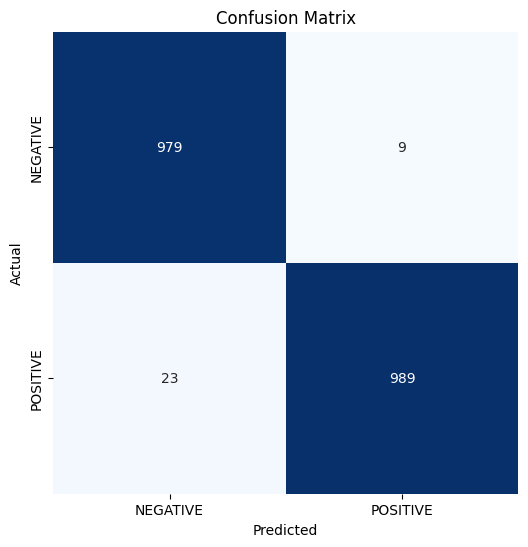

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.98      0.99      0.98       988
    POSITIVE       0.99      0.98      0.98      1012

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [27]:
evaluate_model(model, test_data)

# Testing with new image

In [28]:
pwd

'/content/drive/MyDrive/LAP_intern'

In [29]:
ls

crack_image_detection.ipynb  Negative/  saved_model.h5
Demo/                        Positive/  surface-crack-detection.zip
kaggle.json                  sample/


In [ ]:
# import os

# # Specify the path and name of the new folder
# folder_path = '/content/drive/MyDrive/LAP_intern/sample'

# # Create the folder if it doesn't exist
# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

In [30]:
cd sample/

/content/drive/MyDrive/LAP_intern/sample


In [32]:
# from google.colab import files
# files.upload()

In [33]:
ls

image10.png  image13.png  image1.png  image4.png  image7.png
image11.png  image14.png  image2.png  image5.png  image8.png
image12.png  image15.png  image3.png  image6.png  image9.png


In [34]:
cd ..

/content/drive/MyDrive/LAP_intern


In [35]:
import matplotlib.pyplot as plt

def predict_new_images(model, image_paths, true_labels):
    # Load and preprocess the new images
    new_images = []
    for path in image_paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=(120, 120))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize the pixel values
        new_images.append(img)
    new_images = np.array(new_images)

    # Make predictions on the new images
    predictions = model.predict(new_images)

    # Convert predictions to labels (0 or 1)
    labels = ['NEGATIVE' if pred < 0.5 else 'POSITIVE' for pred in predictions]

    # Display the results
    for path, true_label, predicted_label in zip(image_paths, true_labels, labels):
        img = plt.imread(path)
        plt.imshow(img)
        plt.title("True Label: {}\nPredicted Label: {}".format(true_label, predicted_label))
        plt.axis('off')
        plt.show()

# Provide a list of image paths and true labels for testing
image_paths = [
    '/content/drive/MyDrive/LAP_intern/sample/image1.png',
    '/content/drive/MyDrive/LAP_intern/sample/image2.png',
    '/content/drive/MyDrive/LAP_intern/sample/image3.png',
    '/content/drive/MyDrive/LAP_intern/sample/image4.png',
    '/content/drive/MyDrive/LAP_intern/sample/image5.png',
    '/content/drive/MyDrive/LAP_intern/sample/image6.png',
    '/content/drive/MyDrive/LAP_intern/sample/image7.png',
    '/content/drive/MyDrive/LAP_intern/sample/image8.png',
    '/content/drive/MyDrive/LAP_intern/sample/image9.png',
    '/content/drive/MyDrive/LAP_intern/sample/image10.png',
    '/content/drive/MyDrive/LAP_intern/sample/image11.png',
    '/content/drive/MyDrive/LAP_intern/sample/image12.png',
    '/content/drive/MyDrive/LAP_intern/sample/image13.png',
    '/content/drive/MyDrive/LAP_intern/sample/image14.png',
    '/content/drive/MyDrive/LAP_intern/sample/image15.png'
]

true_labels = [
    'POSITIVE', #1
    'NEGATIVE', #2
    'POSITIVE', #3
    'NEGATIVE', #4
    'POSITIVE', #5
    'NEGATIVE', #6
    'POSITIVE', #7
    'NEGATIVE', #8
    'POSITIVE', #9
    'POSITIVE', #10
    'NEGATIVE', #11
    'POSITIVE', #12
    'NEGATIVE', #13
    'POSITIVE', #14
    'POSITIVE' #15
    # Add true labels corresponding to the image paths
]


# Call the predict_new_images function with the trained model, image paths, and true labels
predict_new_images(model, image_paths, true_labels)


Output hidden; open in https://colab.research.google.com to view.